# Parameter rankings for change across CO2 and climate forcings

- create rankings of parameters that have greatest change in a given variable under CO2 and climate forcing
    - ΔCO2 = C867 - C285
    - Δclimate = AF2095 - AF1855
- focus on ET
- global mean and Whittaker biomes

# Code origin
Most of the code in this notebook is directly copied or modified from Claire Zarakas' code for the coupled CESM PPE which itself was developed from Daniel Kennedy's code for the CLM5.1 PPE.

Claire Zarakas on Github: https://github.com/czarakas/coupled_PPE/blob/main/code/01_select_parameters/Part1_Coupled_PPE_param_selection.ipynb

Daniel Kennedy on Github: https://github.com/djk2120/CLM5PPE/blob/master/pyth/param_selection.ipynb

# Setup

In [1]:
%load_ext watermark
%load_ext autoreload

import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt

%watermark -iv -co -v

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

conda environment: cpl_ppe_co2

xarray    : 2024.6.0
numpy     : 2.0.1
pandas    : 2.2.2
matplotlib: 3.9.1
sys       : 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]



In [2]:
mpl.rcParams['figure.dpi'] = 120

More info about Dask on HPC - https://ncar.github.io/dask-tutorial/notebooks/05-dask-hpc.html

In [3]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    """Code from Daniel Kennedy"""
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        account='UWAS0155', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ext', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [4]:
# Create Dask cluster and client, scale up to 20 workers
cluster, client = get_ClusterClient()
cluster.scale(20)

In [9]:
## Check the status of the cluster
# client

## Prints the PBS job script that is used to submit the Dask workers
# print(cluster.job_script())

## Lists active workers and their status
cluster.workers

## Lists current jobs in Casper queue
# !qstat -u $USER

{'PBSCluster-12': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-0': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-14': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-18': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-17': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-16': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-1': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-8': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-2': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-13': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-5': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-9': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-10': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-4': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-15': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-19': <dask_jobqueue.pbs.PBSJob: status=running>,
 'PBSCluster-7'

In [10]:
def get_params(keys,paramkey):
    '''(Code from Daniel Kennedy)'''
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

In [11]:
def month_wts(nyears):
    '''(Code from Daniel Kennedy)'''
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [12]:
def get_ensemble(name,data_vars,htape,keys,paramkey):
    '''
    (Modified from coode from Daniel Kennedy)
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure and find files
    topdir     = '/glade/campaign/cgd/tss/projects/PPE/PPEn11_OAAT/'
    thisdir    = topdir+name+'/hist/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                           parallel=True,preprocess=preprocess)

    #fix up time dimension
    if htape=='h0':
        ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    extras = ['grid1d_lat','grid1d_lon']
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    
    whit             = xr.open_dataset('./whit/whitkey.nc')
    ds['biome']      = whit['biome']
    ds['biome_name'] = whit['biome_name']
    
    return ds

In [13]:
xr.open_dataset('./whit/whitkey.nc')

<xarray.Dataset> Size: 14kB
Dimensions:     (gridcell: 400, biome_id: 10)
Coordinates:
  * gridcell    (gridcell) int64 3kB 0 1 2 3 4 5 6 ... 394 395 396 397 398 399
  * biome_id    (biome_id) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    biome       (gridcell) float64 3kB ...
    grid1d_lat  (gridcell) float64 3kB ...
    grid1d_lon  (gridcell) float64 3kB ...
    biome_name  (biome_id) <U32 1kB ...

In [14]:
def calc_mean(ds,datavar):
    '''(Code from Claire Zarakas, modified from code from Daniel Kennedy)'''
    cf = cfs[datavar]
    x  = ds[datavar]
    
    da_ann  = cf*(month_wts(10)*(la*x).sum(dim='gridcell')).groupby('time.year').sum(dim='time').compute()
    da_mean = da_ann.mean(dim='year') 
    
    return da_mean,da_ann

In [15]:
def calc_iav(ds,datavar,da_ann=[]):
    '''(Code from Claire Zarakas, modified from code from Daniel Kennedy)'''
    #compute da_ann if not provided
    if len(da_ann)==0:
        cf = cfs[datavar]
        x  = ds[datavar]
        da_ann  = cf*(month_wts(10)*(la*x).sum(dim='gridcell')).groupby('time.year').sum(dim='time').compute()
    da_iav = da_ann.std(dim='year')
    return da_iav

In [16]:
def top_n(da,nx,params,minmax,uniques):
    '''(Code from Daniel Kennedy)'''
    xmins=[];xmaxs=[];dxs=[]
    for u in uniques:
        pair  = find_pair(da,params,minmax,u)
        xmin  = pair[0].values
        xmax  = pair[1].values
        dx    = abs(xmax-xmin)

        xmins.append(xmin)
        xmaxs.append(xmax)
        dxs.append(dx)

    ranks = np.argsort(dxs)

    pvals = [uniques[ranks[i]] for i in range(-nx,0)]
    xmins = [xmins[ranks[i]]   for i in range(-nx,0)]
    xmaxs = [xmaxs[ranks[i]]   for i in range(-nx,0)]
    
    return xmins,xmaxs,pvals

In [17]:
def find_pair(da,params,minmax,p):
    '''
    (Code from Daniel Kennedy)
    returns a subset of da, corresponding to parameter-p
        the returned pair corresponds to [p_min,p_max]
    '''
    ixmin = np.logical_and(params==p,minmax=='min')
    ixmax = np.logical_and(params==p,minmax=='max')
    
    #sub in default if either is missing
    if ixmin.sum().values==0:
        ixmin = params=='default'
    if ixmax.sum().values==0:
        ixmax = params=='default'
        
    emin = da.ens.isel(ens=ixmin).values[0]
    emax = da.ens.isel(ens=ixmax).values[0]

    return da.sel(ens=[emin,emax])

## Load data
I copied the parameter key file and the sparsegrid land area file into my local directory.

In [18]:
# Get the key for which parameters correspond to which ensemble members
# '/glade/u/home/djk2120/oaat_clm5_ppe/pyth/survkey.csv' -> no key column
# '/glade/u/home/djk2120/oaat_clm5_ppe/pyth/depr/surv2.csv'
# '/glade/u/home/czarakas/coupled_PPE/code/01_select_parameters/deprecated/surv.csv' -> same as Daniel's version
paramkey_csv = './surv.csv'
paramkey = pd.read_csv(paramkey_csv)

# Get the sparsegrid land area
# '/glade/u/home/djk2120/oaat_clm5_ppe/pyth/sparsegrid_landarea.nc'
la_nc = './sparsegrid_landarea.nc'
la = xr.open_dataset(la_nc).landarea  # gridcell km2

In [23]:
# pd.read_csv('./survkey.csv')

In [24]:
# pd.read_csv('./surv.csv')

In [19]:
# Choose variables of interest
data_vars = ['EFLX_LH_TOT']
keys = paramkey.key
nens = len(keys)

# Read in the dataset
ds_ctl = get_ensemble('CTL2010', data_vars, 'h0', keys, paramkey)
ds_c285 = get_ensemble('C285', data_vars, 'h0', keys, paramkey)
ds_c867 = get_ensemble('C867', data_vars, 'h0', keys, paramkey)
ds_af1855 = get_ensemble('AF1855', data_vars, 'h0', keys, paramkey)
ds_af2095 = get_ensemble('AF2095', data_vars, 'h0', keys, paramkey)

In [21]:
# ds_ctl

In [29]:
# Calculate new variables (if needed)
# ds['ALBEDO_allSW'] = ds['FSR'] / ds['FSDS']

# data_vars = data_vars + ['ALBEDO_allSW']

In [47]:
# cfs = dict()    # Conversion Factors
# units = dict()

# #intensives (need to account for landarea)
# lasum = la.sum()
# for field in data_vars:
#     cfs[field]   = 1 / lasum / 365
#     units[field] = ds[field].attrs['units']

NameError: name 'ds' is not defined

In [48]:
# Get unique parameters, excluding 'default'
uniques = list(np.unique(ds.param))
uniques.remove('default')

# Store the parameter names and minmax across ensemble (mask-like)
params = ds.param
minmax = ds.minmax

# Calculate parameter rankings

## (1) *Global Mean*

In [49]:
ds = ds_ctl

cutoff_num =5
params_top5 = []
params_biome = []
params_criteria = []
params_rank = []
params_variable = []
params_measure = []

for datavar in data_vars:
    print(datavar)
    [da_mean,da_ann] = calc_mean(ds, datavar)
    iav = calc_iav(ds, datavar, da_ann=da_ann)
    
    # Mean
    [xmins,xmaxs,pvals] = top_n(da_mean,
                                cutoff_num,params,minmax,uniques)
    pvals.reverse()
    xmins.reverse()
    xmaxs.reverse()
    params_top5 = params_top5 + pvals[0:cutoff_num]
    params_biome = params_biome+['global']*cutoff_num
    params_criteria = params_criteria+[datavar+'_MEAN_global']*cutoff_num
    params_rank = params_rank+np.arange(1,cutoff_num+1).tolist()
    params_variable = params_variable+[datavar]*cutoff_num
    params_measure = params_measure+['mean']*cutoff_num

    # IAV
    [xmins,xmaxs,pvals] = top_n(iav,cutoff_num,params,minmax,uniques)
    pvals.reverse()
    xmins.reverse()
    xmaxs.reverse()
    params_top5 = params_top5 + pvals[0:cutoff_num]
    params_biome = params_biome+['global']*cutoff_num
    params_criteria = params_criteria+[datavar+'_IAV_global']*cutoff_num
    params_rank = params_rank+np.arange(1,cutoff_num+1).tolist()
    params_variable = params_variable+[datavar]*cutoff_num
    params_measure = params_measure+['iav']*cutoff_num

EFLX_LH_TOT


In [50]:
# Create dictionary of lists 
df_global = pd.DataFrame({'param_name': params_top5, 
                          'biome':      params_biome, 
                          'criteria':   params_criteria, 
                          'rank':       params_rank,
                          'variable':   params_variable,
                          'measure':    params_measure} )

In [51]:
df_global

,param_name,biome,criteria,rank,variable,measure
0,kmax,global,EFLX_LH_TOT_MEAN_global,1,EFLX_LH_TOT,mean
1,fff,global,EFLX_LH_TOT_MEAN_global,2,EFLX_LH_TOT,mean
2,medlynslope,global,EFLX_LH_TOT_MEAN_global,3,EFLX_LH_TOT,mean
3,liq_canopy_storage_scalar,global,EFLX_LH_TOT_MEAN_global,4,EFLX_LH_TOT,mean
4,medlynintercept,global,EFLX_LH_TOT_MEAN_global,5,EFLX_LH_TOT,mean
5,frac_sat_soil_dsl_init,global,EFLX_LH_TOT_IAV_global,1,EFLX_LH_TOT,iav
6,fff,global,EFLX_LH_TOT_IAV_global,2,EFLX_LH_TOT,iav
7,d_max,global,EFLX_LH_TOT_IAV_global,3,EFLX_LH_TOT,iav
8,sand_pf,global,EFLX_LH_TOT_IAV_global,4,EFLX_LH_TOT,iav
9,vcmaxhd,global,EFLX_LH_TOT_IAV_global,5,EFLX_LH_TOT,iav


## (2) *Whittaker biomes*

In [69]:
env = 'C867'

#@njit  # numba: set "nopython" mode for best performance
def calc_mean_biome(dsb,datavar,lab):

    domain='biome'
    preload = './biome/'+env+'_'+datavar+'_'+domain+'.nc'
    
    if not glob.glob(preload):
        #do the calculation
        cf = cfs[datavar]  #conversion factor
        if cf=='intrinsic':
            cf = 1/lab.groupby('biome').sum()/365
        x  = dsb[datavar]

        #calc annual mean or sum (determined by cf)
        xann = cf*(month_wts(10)*(lab*x).groupby('biome').sum()).groupby('time.year').sum().compute()

        #average/iav
        xm  = xann.mean(dim='year') 
        iav = xann.std(dim='year')

        #save the reduced data
        out = xr.Dataset()
        out[datavar+'_mean'] = xm
        out[datavar+'_mean'].attrs= {'units':units[datavar]}
        out[datavar+'_iav']  = iav
        out[datavar+'_iav'].attrs= {'units':units[datavar]}
        out['param']  = dsb.param
        out['minmax'] = dsb.minmax
        out.load().to_netcdf(preload)

    #load from file if available
    ds  = xr.open_dataset(preload)
    xm  = ds[datavar+'_mean']
    iav = ds[datavar+'_iav']
    
    return xm,iav

In [70]:
la['biome']=ds['biome']
lab = la.swap_dims({'gridcell':'biome'})
dsb = ds.swap_dims({'gridcell':'biome'})

In [71]:
cutoff_num = 5
params_top5 = []
params_biome = []
params_criteria = []
params_rank = []
params_variable = []
params_measure = []

uniques = list(np.unique(ds.param))
uniques.remove('default')

for datavar in data_vars:
    print(datavar)
    da,iav = calc_mean_biome(dsb,datavar,lab)
    #print('calculated')
    
    for i in np.arange(0,10):
        b = str(dsb.biome_name.isel(biome_id=i).values)
        
        [xmins,xmaxs,pvals] = top_n(da.isel(biome=i),
                                    10,params,minmax,uniques)
        pvals.reverse()
        xmins.reverse()
        xmaxs.reverse()
        params_top5 = params_top5 + pvals[0:cutoff_num]
        params_biome = params_biome+[b]*cutoff_num
        params_criteria = params_criteria+[da.name+'_'+b]*cutoff_num
        params_rank = params_rank+np.arange(1,cutoff_num+1).tolist()
        params_variable = params_variable+[datavar]*cutoff_num
        params_measure = params_measure+['mean']*cutoff_num
        
        [xmins,xmaxs,pvals] = top_n(iav.isel(biome=i),
                                    10,params,minmax,uniques)
        pvals.reverse()
        xmins.reverse()
        xmaxs.reverse()
        params_top5 = params_top5 + pvals[0:cutoff_num]
        params_biome = params_biome+[b]*cutoff_num
        params_criteria = params_criteria+[iav.name+'_'+b]*cutoff_num
        params_rank = params_rank+np.arange(1,cutoff_num+1).tolist()
        params_variable = params_variable+[datavar]*cutoff_num
        params_measure = params_measure+['iav']*cutoff_num
        
        #print(pvals[0:5])

EFLX_LH_TOT


In [72]:
# Create dictionary of lists 
df_biomes = pd.DataFrame({'param_name': params_top5, 
                          'biome':      params_biome, 
                          'criteria':   params_criteria, 
                          'rank':       params_rank,
                          'variable':   params_variable,
                          'measure':    params_measure} )

In [73]:
df_biomes.loc[df_biomes['rank'] == 1]

,param_name,biome,criteria,rank,variable,measure
0,zetamaxstable,Ice sheet,EFLX_LH_TOT_mean_Ice sheet,1,EFLX_LH_TOT,mean
5,zsno,Ice sheet,EFLX_LH_TOT_iav_Ice sheet,1,EFLX_LH_TOT,iav
10,kmax,Tropical rain forest,EFLX_LH_TOT_mean_Tropical rain forest,1,EFLX_LH_TOT,mean
15,maximum_leaf_wetted_fraction,Tropical rain forest,EFLX_LH_TOT_iav_Tropical rain forest,1,EFLX_LH_TOT,iav
20,kmax,Tropical seasonal forest/savanna,EFLX_LH_TOT_mean_Tropical seasonal forest/savanna,1,EFLX_LH_TOT,mean
25,frac_sat_soil_dsl_init,Tropical seasonal forest/savanna,EFLX_LH_TOT_iav_Tropical seasonal forest/savanna,1,EFLX_LH_TOT,iav
30,fff,Subtropical desert,EFLX_LH_TOT_mean_Subtropical desert,1,EFLX_LH_TOT,mean
35,fff,Subtropical desert,EFLX_LH_TOT_iav_Subtropical desert,1,EFLX_LH_TOT,iav
40,maximum_leaf_wetted_fraction,Temperate rain forest,EFLX_LH_TOT_mean_Temperate rain forest,1,EFLX_LH_TOT,mean
45,maximum_leaf_wetted_fraction,Temperate rain forest,EFLX_LH_TOT_iav_Temperate rain forest,1,EFLX_LH_TOT,iav


### Figures for EFLX_LH_TOT

In [74]:
datavar = 'EFLX_LH_TOT'
da,iav = calc_mean_biome(dsb,datavar,lab)

In [75]:
def plot20(da, nx, tstr, ll=True, xstr=''):

    uniques = list(np.unique(ds.param))
    uniques.remove('default')

    xmins, xmaxs, pvals = top_n(da, nx, params, minmax, uniques)
    xdef = da.isel(ens=0)
    unit = da.attrs['units']

    if len(xstr) == 0:
        xstr = tstr
    nx = len(pvals)
    plt.plot([xdef, xdef], [0, nx-1], 'k:', label='default')
    plt.scatter(xmins, range(nx), marker='o', facecolors='none',
                edgecolors='r', label='low-val')
    plt.plot(xmaxs, range(nx), 'ro', label='high-val')
    if ll:
        plt.legend(loc=3)
    i = -1
    for xmin, xmax in zip(xmins, xmaxs):
        i += 1
        plt.plot([xmin, xmax], [i, i], 'r')
    plt.yticks(range(nx), pvals)
    plt.title(tstr)
    plt.xlabel(xstr+' ('+unit+')')

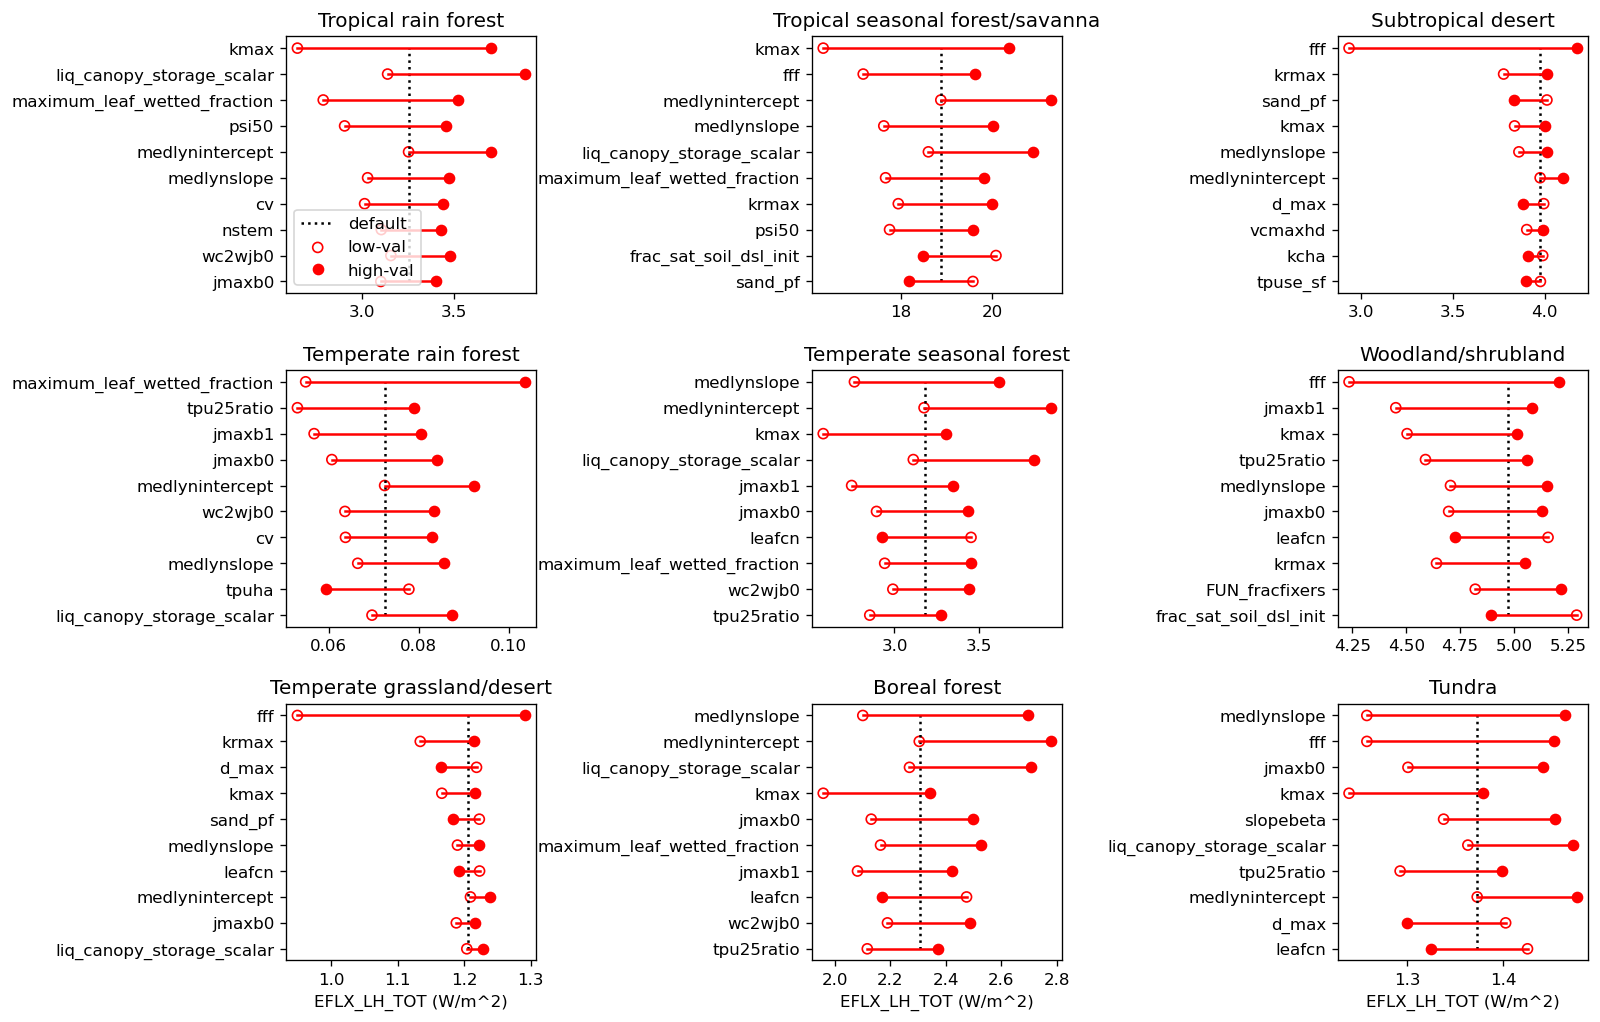

In [79]:
# exclude ice sheet
plt.figure(figsize=[14, 10])
ll = True
for i in 1+np.arange(9):
    plt.subplot(3, 3, i)

    b = str(dsb.biome_name.isel(biome_id=i).values)

    plot20(da.isel(biome=i), 10, b, ll=ll, xstr=datavar)
    ll = False
    if i < 7:
        plt.xlabel('')

plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=1.1)

## (3) *Global hotspot coupling*

# !! KILL DASK !!

In [ ]:
# client.shutdown()
# !rm ./dask-worker.e*
# !rm ./dask-worker.o*